In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfea
import cartopy.io.shapereader as shapereader

In [2]:
#
rgndir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/region'
glbdir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city'
#
tag = '.ro5'
city_num = 16
#
resolution = 12
POP='vld_cty_'
#
SUF = '.gl5'
dtype = 'float32'
gl5shape = (2160, 4320)
#
# region
left = -47
right = -40
bottom = -24
top = -20
#
nx, ny = (right - left)*resolution, (top - bottom)*resolution
rgnshape = (ny, nx)
img_extent = (left, right, bottom, top)
#
upperindex = (90-top)*resolution
lowerindex = (90-bottom)*resolution
leftindex = (180+left)*resolution
rightindex = (180+right)*resolution

In [3]:
#---------------------------------------------------------------------------------------------------------------
#  city maskの枠だけを表示
#---------------------------------------------------------------------------------------------------------------
def draw_mask_sotowaku(extent, mask_cropped, ax=None, sotowaku_color='#dc143c', linewidth=3):
    """
    zorder = 0: デフォルトの最背面(gridをzorder=0に設定)
    zorder = 1: 赤色の外枠(citymask)
    zorder = 2: 白色の内枠が最前面(citymask)
    """

    # delta
    delta = 360/4320
    x_left = extent[0]
    y_top = extent[3]
    
    # outer
    upper_indices = []
    lower_indices = []
    left_indices = []
    right_indices = []
    rows, cols = mask_cropped.shape
    for i in range(rows):
        for j in range(cols):
            if mask_cropped[i, j] == 1:
                if mask_cropped[i-1, j] == 0:
                    upper_indices.append((i, j))
                if mask_cropped[i+1, j] == 0:
                    lower_indices.append((i, j))
                if mask_cropped[i, j-1] == 0:
                    left_indices.append((i, j))
                if mask_cropped[i, j+1] == 0:
                    right_indices.append((i, j))

    # extent
    projection = ccrs.PlateCarree()

    # city mask
    for up in upper_indices:
        x_index = x_left + delta*(up[1])
        y_index = y_top - delta*(up[0])
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # top
        ax.plot([x_index, x_index+delta], [y_index, y_index], color='white', transform=projection, linewidth=linewidth-2, zorder=2) # top
    for lo in lower_indices:
        x_index = x_left + delta*(lo[1])
        y_index = y_top - delta*(lo[0]+1)
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # bottom
        ax.plot([x_index, x_index+delta], [y_index, y_index], color='white', transform=projection, linewidth=linewidth-2, zorder=2) # bottom
    for le in left_indices:
        x_index = x_left + delta*(le[1])
        y_index = y_top - delta*(le[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # left
        ax.plot([x_index, x_index], [y_index, y_index+delta], color='white', transform=projection, linewidth=linewidth-2, zorder=2) # left
    for ri in right_indices:
        x_index = x_left + delta*(ri[1]+1)
        y_index = y_top - delta*(ri[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # right
        ax.plot([x_index, x_index], [y_index, y_index+delta], color='white', transform=projection, linewidth=linewidth-2, zorder=2) # right

    return ax

import random
import cartopy.crs as ccrs
import cartopy.feature as cfea
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from matplotlib.colors import CSS4_COLORS
from matplotlib.patches import Rectangle

#---------------------------------------------------------------------------------------------------------------
# 流域IDと色の紐付け(kakiuchi's method) this is deprecated
#---------------------------------------------------------------------------------------------------------------

def get_unique_non_masked_values(values):
    result = []
    for value in np.unique(values):
        if value is not np.ma.masked and not np.isnan(value):
            result.append(value)
    return result

def is_grayish(color):
    r, g, b = [int(color[i:i+2], 16) for i in (1, 3, 5)]  # Convert hex to RGB
    deviation = max(r, g, b) - min(r, g, b)
    return deviation <= 20

def is_blueish(color):
    r, g, b = [int(color[i:i+2], 16) for i in (1, 3, 5)]  # Convert hex to RGB
    return (b - r > 120 and b - g > 120) or (r < 100 and g< 100 and b > 150)  # If blue is dominant and significantly larger
    
def is_whitish(color):
    r, g, b = [int(color[i:i+2], 16) for i in (1, 3, 5)]  # Convert hex to RGB
    return  (r + g + b)/3 > 230

def get_filtered_colors():
    all_colors = list(CSS4_COLORS.values())
    result = []
    ng_color = ['#3F2E6' '#00FFFF', '#B3F2E6', '#7FFFD4', '#2A3F54', '#B3F2F9', '#00FF00']
    for color in all_colors:
        if color not in ng_color \
            and not is_grayish(color) \
            and not is_whitish(color):
            result.append(color)
    return result

def make_cmap(Rivnum_masked_array):
    # ユニークな流域の数をカウント
    unique_values = get_unique_non_masked_values(Rivnum_masked_array)
    num_colors = len(unique_values)

    # 流域に固有の色を割り振る
    filtered_colors = get_filtered_colors()
    #random.seed(42)
    #colors_list = (random.choices(filtered_colors, k=num_colors))
    colors_list = filtered_colors[:num_colors]

    # -1<=x<0に透明色を追加
    colors_list.insert(0, '#00000000')

    # HTMLカラーコードに変化してlisted colormap を作成
    cmap = ListedColormap(colors_list)

    # [辞書作る] key=流域ID, value=0から数えたindex　
    index_dict = {}
    for i, value in enumerate(unique_values):
        index_dict[value] = i

    return num_colors, index_dict, cmap

def get_index(val, index_dict):
    return index_dict.get(val, -1)  # nan or unexpected values are mapped to -1

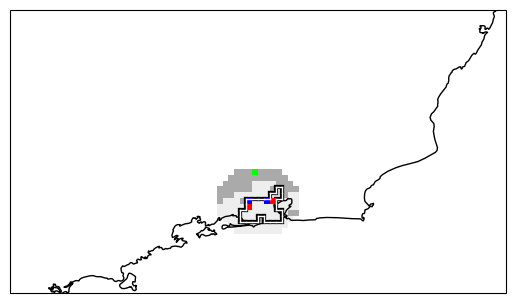

In [4]:
# explored file
# 1: explored area
# 2: candidate points
exp_cand = np.fromfile(f'{glbdir}/dat/cty_int_/fig/intake_display_{POP}_{city_num:08}{SUF}', dtype='float32').reshape(gl5shape)
exp_cand_cropped = exp_cand[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]
exp_cand_masked = np.ma.masked_where(exp_cand_cropped==0, exp_cand_cropped)
cm = colors.ListedColormap(["#EEEEEE", "#AAAAAA"])

# estimated intake
intake = np.fromfile(f'{glbdir}/dat/cty_int_/{POP}/city_{city_num:08}{SUF}', dtype='float32').reshape(gl5shape)
intake_cropped = intake[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]
#intake_masked = np.ma.masked_where(intake_cropped==0, intake_cropped)
cmap_intake = colors.ListedColormap(['none', 'lime'])

# city mask
mask = np.fromfile(f'{glbdir}/dat/{POP}/city_{city_num:08}{SUF}', dtype='float32').reshape(gl5shape)
mask_cropped = mask[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]

# josui
josui = np.fromfile(f'{glbdir}/dat/cty_prf_/{POP}/city_{city_num:08}{SUF}', dtype='float32').reshape(gl5shape)
josui_cropped = josui[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]
cmap_josui = colors.ListedColormap(['none', 'blue'])

# gesui
gesui = np.fromfile(f'{glbdir}/dat/cty_swg_/{POP}/city_{city_num:08}{SUF}', dtype='float32').reshape(gl5shape)
gesui_cropped = gesui[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]
cmap_gesui = colors.ListedColormap(['none', 'red'])

# draw
projection = ccrs.PlateCarree()
fig = plt.figure()
ax = plt.subplot(projection=projection)
ax.set_extent(img_extent)
ax.coastlines()

im = ax.imshow(exp_cand_masked, extent=img_extent, transform=projection, cmap=cm, vmin=1, vmax=2, zorder=0)
im2 = ax.imshow(intake_cropped, extent=img_extent, transform=projection, cmap=cmap_intake, zorder=2)
im3 = ax.imshow(josui_cropped, extent=img_extent, transform=projection, cmap=cmap_josui, zorder=2)
im4 = ax.imshow(gesui_cropped, extent=img_extent, transform=projection, cmap=cmap_gesui, zorder=2)
draw_mask_sotowaku(img_extent, mask_cropped, ax=ax, sotowaku_color='black')

# tokyo shapefile
shpfilename = shapereader.natural_earth(resolution='10m', category='cultural', name='admin_1_states_provinces')
provinces = shapereader.Reader(shpfilename).records()
provinces_of_japan = filter(
    lambda province: province.attributes['admin'] == 'Japan', provinces)
for province in provinces_of_japan:
    geometry = province.geometry
    ax.add_geometries([geometry], ccrs.PlateCarree(), facecolor='none', linestyle=':', zorder=0)

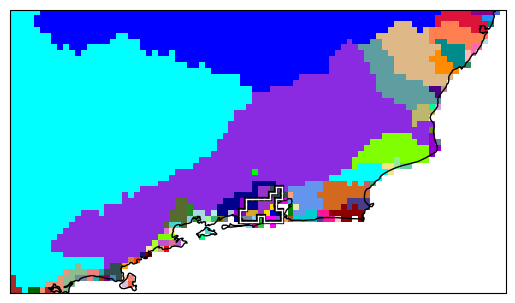

In [6]:
# rivnum
rivnum = np.fromfile(f'{glbdir}/dat/riv_num_/rivnum.CAMA.gl5', dtype='float32').reshape(gl5shape)
rivnum_cropped = rivnum[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]
rivnum_cropped = np.ma.masked_where(rivnum_cropped == 0, rivnum_cropped)
num_colors, index_dict, cmap = make_cmap(rivnum_cropped)
data_masked = np.ma.masked_where(rivnum_cropped >= 1e20, rivnum_cropped)
data_filled = data_masked.filled(0)
indexed_data = np.vectorize(get_index)(data_filled, index_dict)

# draw
projection = ccrs.PlateCarree()
fig = plt.figure()
ax = plt.subplot(projection=projection)
ax.set_extent(img_extent)
ax.coastlines()

im = ax.imshow(intake_cropped, extent=img_extent, transform=projection, cmap=cmap_intake, zorder=1)
im2 = ax.imshow(indexed_data, extent=img_extent, transform=projection, cmap=cmap, vmin=-2, zorder=0)
draw_mask_sotowaku(img_extent, mask_cropped, ax=ax, sotowaku_color='black')

shpfilename = shapereader.natural_earth(resolution='10m', category='cultural', name='admin_1_states_provinces')
provinces = shapereader.Reader(shpfilename).records()
provinces_of_japan = filter(
    lambda province: province.attributes['admin'] == 'Japan', provinces)
for province in provinces_of_japan:
    geometry = province.geometry
    ax.add_geometries([geometry], ccrs.PlateCarree(), facecolor='none', linestyle=':', zorder=10)

In [7]:
shpfilename = shapereader.natural_earth(resolution='10m', category='cultural', name='admin_1_states_provinces')
provinces = shapereader.Reader(shpfilename).records()
cname = []
for province in provinces:
    cname.append(province.attributes['admin'])
unique = np.unique(cname)
print(unique)

['Afghanistan' 'Akrotiri Sovereign Base Area' 'Aland' 'Albania' 'Algeria'
 'American Samoa' 'Andorra' 'Angola' 'Anguilla' 'Antarctica'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba'
 'Ashmore and Cartier Islands' 'Australia' 'Austria' 'Azerbaijan'
 'Bahrain' 'Bangladesh' 'Barbados' 'Baykonur Cosmodrome' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bermuda' 'Bhutan' 'Bolivia'
 'Bosnia and Herzegovina' 'Botswana' 'Brazil'
 'British Indian Ocean Territory' 'British Virgin Islands' 'Brunei'
 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cambodia' 'Cameroon' 'Canada'
 'Cape Verde' 'Caribbean Netherlands' 'Cayman Islands'
 'Central African Republic' 'Chad' 'Chile' 'China' 'Clipperton Island'
 'Colombia' 'Comoros' 'Cook Islands' 'Coral Sea Islands' 'Costa Rica'
 'Croatia' 'Cuba' 'Curaçao' 'Cyprus' 'Czech Republic'
 'Democratic Republic of the Congo' 'Denmark'
 'Dhekelia Sovereign Base Area' 'Djibouti' 'Dominica' 'Dominican Republic'
 'East Timor' 'Ecuador' 'Egypt' 'El Salvador' 'Equatorial Guinea'
 'E